In [67]:
source("./Functions/MOCL.R") 
source("./Functions/lambda_selection.R")
source("./Functions/MOCL_wcss.R")
source("./Functions/Adaptive_MAM.R") 

source("./Functions/SKM_gap.R")
source("./Functions/evaluation.R")


library(VarSelLCM) # VarselLCM
library(cluster)     # PAM

library(ggplot2)
library(gridExtra)
library(ggpubr)
library(ggthemes)
library(GGally)
library(RColorBrewer)
library(corrplot)
library(dplyr)
library(pdfCluster)
library(fossil)
options(warn=-1)
library(Rtsne)
library(latex2exp)

# CHR

In [127]:
clu_kk=c(1:4)
mu_or=1

x1=mu_or*2*clu_kk
x2=-mu_or*(1/10)*exp(clu_kk)
x3=mu_or*7*log(clu_kk)

mu_mat_or=cbind(x1,x2,x3)
mu_v_or=apply(mu_mat_or,2,mean)

for(i in 1:4){
    if(i==1){
        m_or=mu_mat_or[i,]%*%t(mu_mat_or[i,])
    }else{
        m_or=m_or+mu_mat_or[i,]%*%t(mu_mat_or[i,])
    }
}
bc_or=sum(diag(m_or/4-mu_v_or%*%t(mu_v_or)))
wc_or=sum(diag(4^(-1)*4*diag(3)))

CHI_or=bc_or/wc_or


###################################
mu_no=6.32
mu_mat_no=mu_no*diag(4)
mu_v_no=apply(mu_mat_no,2,mean)

for(i in 1:4){
    if(i==1){
        m_no=mu_mat_no[i,]%*%t(mu_mat_no[i,])
    }else{
        m_no=m_no+mu_mat_no[i,]%*%t(mu_mat_no[i,])
    }
}
bc_no=sum(diag(m_no/4-mu_v_no%*%t(mu_v_no)))
wc_no=sum(diag(4^(-1)*4*diag(4)))

CHI_no=bc_no/wc_no


sqrt(CHI_no/CHI_or)

[1] 1.001418

# Simulation setting function

In [5]:
setting_K4<-function(mu_or=1,n_k_lst=c(50,50,50,50),
                                p=20,seed=1234,mu_no=10){
    set.seed(seed)
    K=length(n_k_lst)
    n=sum(n_k_lst)
    
    for(i in 1:K){
        if(i==1){
            clu_k=c(rep(i,n_k_lst[i]))
        }else{
            clu_k=c(clu_k,rep(i,n_k_lst[i]))
        }
    }
    
    mu_1=mu_or*(2*clu_k)
    mu_2=-mu_or*(exp(clu_k)/10)
    mu_3=mu_or*(7*log(clu_k))
    
    
    # Data generation
    x1=mu_1+rnorm(n,0,1)
    x2=mu_2+rnorm(n,0,1)
    x3=mu_3+rnorm(n,0,1)
    
    data_x=scale(cbind(x1,x2,x3))
    
    ############################
    # Data corresponding to nominal clusters
    mu_no_mat=diag(K)
    
    # Nominal cluster generation
    x_no=matrix(0,n,ncol(mu_no_mat))
    p_lst=runif(n,0,1)
    clu_no=p_lst*0
    for(i in 1:K){
        clu_no=clu_no+(p_lst>=((i-1)/K))
    }
    #clu_no
    for(i in 1:nrow(x_no)){
        x_no[i,]=mu_no*mu_no_mat[clu_no[i],]
    }

    for(i in 1:ncol(x_no)){
        x_no[,i]=x_no[,i]+rnorm(nrow(x_no),0,1)
    }

    colnames(x_no)=paste("x_no",1:(ncol(x_no)),sep="_")
    
    ###############################
    # Noise variables
    p_e=p-ncol(data_x)-ncol(x_no)
    noise_mat=nor_minmax(matrix(rnorm(n*p_e,0,1),n,p_e))
    colnames(noise_mat)=paste("noise",1:(ncol(noise_mat)),sep="_")
    
    data=scale(cbind(data_x,x_no,noise_mat))
    
    ## clustering
    kk=K
    pam <- pam(data,kk)
    km <- KMeans_rcpp(data,kk)
    mocl <- MOCL_wcss(Xf=data,k=kk,lambda_seq=seq.default(from=0.001,to=3,length=50),delta=0.01)
    skm <- Sparse_km(data=data,kk=kk,nperms_n=10)
    varsel <- VarSelCluster(data, kk, nbcores = 2, crit.varsel = 'BIC') 
    
    
    # clusters
    cluster_mat=rbind(mocl$cluster,
                     skm$cluster_best,
                     skm$cluster_1sd,
                     fitted(varsel),
                     km$cluster,
                     pam$cluster)
    
    rownames(cluster_mat)=c("MOCL_wcss","SKM_best","SKM_1sd","VSL","KMPP","PAM")
    
    sparse_mat=rbind(t(matrix(apply(abs(mocl$fx),2,sum)>0)),
                    skm$sparse_best,skm$sparse_1sd,
                     slot(slot(varsel,'model'),'omega'))
    
    rownames(sparse_mat)=c("MOCL","SKM_best","SKM_1sd","VSL")
    
    rand_mat=t(matrix(c(rand.index(clu_k,mocl$cluster),
                         rand.index(clu_k,skm$cluster_best),
                         rand.index(clu_k,skm$cluster_1sd),
                         rand.index(clu_k,fitted(varsel)),
                         rand.index(clu_k,km$cluster),
                         rand.index(clu_k,pam$cluster))))
    
    colnames(rand_mat)=c("MOCL","SKM_best","SKM_1sd","VSL","KMPP","PAM")
    kendall=cor(clu_k,mocl$cluster,method="kendall")
    
    
    if(p==ncol(data_x)){
        TP_FP_mat=cbind(apply(sparse_mat[,c(1:ncol(data_x))],1,mean),
                        c(rep(0,nrow(sparse_mat))))
    }
    if(p>ncol(data_x)){
        TP_FP_mat=cbind(apply(sparse_mat[,c(1:ncol(data_x))],1,mean),
                    apply(sparse_mat[,c((ncol(data_x)+1):ncol(sparse_mat))],1,mean))
    }
    
    rand_no=rand.index(clu_k,clu_no)
    return(list(cluster=clu_k,clu_no=clu_no,rand_no=rand_no,cluster_mat=cluster_mat,data=data,mocl_lam=mocl$lambda_sel_mat,
                sparse_mat=sparse_mat,rand_mat=rand_mat,TP_FP_mat=TP_FP_mat,kendall=kendall,
                fx_mocl=mocl$fx,
                coef_mocl=mocl$coef,
                weight_skm=skm$weigth_best,weight_skm_1sd=skm$weigth_1sd))
}

# Iteration

In [8]:
iter_n=100

In [128]:
ss=11021
set.seed(ss)
seed_r=round(runif(20000,1,30000))

models_or=list()


models_0=list()
models_1=list()
models_2=list()
models_3=list()
models_4=list()
models_5=list()
models_6=list()
models_7=list()
models_8=list()
models_9=list()
models_10=list()
models_11=list()

Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[110*i+102]
    models_0[[i]]=setting_K4(mu_or=1,p=20,seed=seed_rr,mu_no=6.32*0)
}

Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[110*i+1002]
    models_1[[i]]=setting_K4(mu_or=1,p=20,seed=seed_rr,mu_no=6.32*0.2)  
}
Sys.time()




In [9]:
ss=11021
set.seed(ss)
seed_r=round(runif(20000,1,30000))

models_or=list()


models_0=list()
models_1=list()
models_2=list()
models_3=list()
models_4=list()
models_5=list()
models_6=list()
models_7=list()
models_8=list()
models_9=list()
models_10=list()
models_11=list()

Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[110*i+102]
    models_0[[i]]=setting_K4(mu_or=1,p=20,seed=seed_rr,mu_no=6.32*0)
}

Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[110*i+1002]
    models_1[[i]]=setting_K4(mu_or=1,p=20,seed=seed_rr,mu_no=6.32*0.2)  
}
Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[11*i+2100]+33 
    models_2[[i]]=setting_K4(mu_or=1,p=20,seed=seed_rr,mu_no=6.32*0.4)  
}
Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[17*i+20]
    models_3[[i]]=setting_K4(mu_or=1,p=20,seed=seed_rr,mu_no=6.32*0.6)
}
Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[14*i+203];
    models_4[[i]]=setting_K4(mu_or=1,p=20,seed=seed_rr,mu_no=6.32*0.8)
}
Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[i+7000];
    models_5[[i]]=setting_K4(mu_or=1,p=20,seed=seed_rr,mu_no=6.32*1.0)
}
Sys.time()


for(i in 1:iter_n){
    seed_rr=seed_r[i+8000];
    models_6[[i]]=setting_K4(mu_or=1,p=20,seed=seed_rr,mu_no=6.32*1.2)
}
Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[300+3*i];
    models_7[[i]]=setting_K4(mu_or=1,p=20,seed=seed_rr,mu_no=6.32*1.4)
}
Sys.time()

Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[70+10*i];
    models_8[[i]]=setting_K4(mu_or=1,p=20,seed=seed_rr,mu_no=6.32*1.6)
}
Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[2000+7*i];
    models_9[[i]]=setting_K4(mu_or=1,p=20,seed=seed_rr,mu_no=6.32*1.8)
}
Sys.time()

for(i in 1:iter_n){
    seed_rr=seed_r[120+5*i];
    models_10[[i]]=setting_K4(mu_or=1,p=20,seed=seed_rr,mu_no=6.32*2)
}
Sys.time()



[1] "2024-01-31 00:14:11 KST"

0123
01234
0123
0123
0123
0123
01234
0123
0123
0123
0123
0123
012
012
0123
0123
0123
0123
0123
0123
0123
012
0123
0123
0123
0123
0123
0123
0123
0123
012
012
01234
0123
01234
012
0123
0123
0123
0123
0123
012
0123
0123
012
012
0123
0123
0123
0123
01234
012
0123
0123
012
0123
012
0123
012
0123
0123
012
0123
0123
0123
012
0123
0123
0123
0123
0123
0123
0123
0123
0123
0123
0123
012
012
012
0123
0123
01234
0123
0123
012
01234
0123
0123
0123
0123
012
0123
0123
01234
01234
0123
0123
01234
0123
012
0123
0123
0123
0123
0123
0123
012
012
0123
012
012
012
012
0123
0123
012
01234
0123
012
012
0123
0123
0123
012
012
0123
0123
0123
012
01234
012
0123
012
0123
0123
0123
0123
0123
0123
0123
012
0123
012
0123
0123
01234
0123
012
012
0123
0123
0123
0123
0123
0123
0123
0123
0123
012
0123
012
0123
0123
0123
0123
0123
012
0123
0123
0123
0123
0123
012
012
012
0123
012
0123
0123
0123
01234
0123
0123
01234
012
0123
0123
01234
0123
0123
0123
0123
0123
0123
012
0123
0123
0123
0123


[1] "2024-01-31 00:42:56 KST"

0123
0123
0123
01234
012
0123
01234
012
0123
0123
0123
0123
0123
012
0123
0123
0123
0123
0123
0123
01234
01234
0123
0123
0123
012345
01234
012
0123
0123
0123
0123
0123
012
012
0123
0123
012
012345
012
0123
0123
012
0123
012
012
0123
01234
0123
0123
0123
0123
0123
0123
012
0123
012
012
0123
0123
0123
012
012
0123
0123
012
012
012
0123
012
0123
0123
0123
012
0123
0123
01234
0123
01234
01234
0123
0123
0123
0123
0123
01234
0123
0123
012
0123
012345
0123
012
0123
01234
0123
01234
0123
0123
0123
0123
012
0123
01234
0123
0123
0123
012
012
0123
0123
0123
012
01234
0123
01234
0123
01234
0123
0123
0123
012
0123
0123
0123
0123
0123
0123
012
012
0123
012
0123
0123
01234
0123
0123
0123
0123
012
0123
0123
0123
0123
0123
0123
01234
0123
0123
0123
012
012
0123
0123
0123
0123
012345
012
0123
0123
0123
0123
012
0123
0123
01234
0123
0123
0123
0123
01234
012
0123
012
0123
012
01234
012
0123
012
0123
0123
0123
012
0123
0123
0123
012
012
012
0123
0123
0123
0123
012
012
01234
0123
0123
0123


[1] "2024-01-31 01:14:07 KST"

# Results

In [27]:
mm_lst=list()
mm_lst[[1]]=models_0
mm_lst[[2]]=models_1
mm_lst[[3]]=models_2
mm_lst[[4]]=models_3
mm_lst[[5]]=models_4
mm_lst[[6]]=models_5
mm_lst[[7]]=models_6
mm_lst[[8]]=models_7
mm_lst[[9]]=models_8
mm_lst[[10]]=models_9
mm_lst[[11]]=models_10



In [110]:
for(i in 1:length(mm_lst)){
    if(i==1){
        rand_mat=round(rand_summary(mm_lst[[i]])$rand_mean,3)
    }else{
        rand_mat=rbind(rand_mat,round(rand_summary(mm_lst[[i]])$rand_mean,3))
    }
}

for(i in 1:length(mm_lst)){
    if(i==1){
        rand_no_mat=round(rand_no_summary(mm_lst[[i]])$rand_no_mean,3)
    }else{
        rand_no_mat=rbind(rand_no_mat,round(rand_no_summary(mm_lst[[i]])$rand_no_mean,3))
    }
}

In [111]:
var_acc<-function(models,index=c(1,2,3)){
    for(i in 1:length(models)){
        if(i==1){
            acc=apply(models[[i]]$sparse_mat[,index],1,mean)
        }else{
            acc=rbind(acc,apply(models[[i]]$sparse_mat[,index],1,mean))
        }
    }
    acc_mean=apply(acc,2,mean)
    return(acc_mean)
}

for(i in 1:length(mm_lst)){
    if(i==1){
        tp_ord=var_acc(models=mm_lst[[i]],index=c(1,2,3))[-2]
        tp_nom=var_acc(models=mm_lst[[i]],index=c(4,5,6,7))[-2]
        tp_noi=var_acc(models=mm_lst[[i]],index=c(8:20))[-2]
    }else{
        tp_ord=rbind(tp_ord,var_acc(models=mm_lst[[i]],index=c(1,2,3))[-2])
        tp_nom=rbind(tp_nom,var_acc(models=mm_lst[[i]],index=c(4:7))[-2])
        tp_noi=rbind(tp_noi,var_acc(models=mm_lst[[i]],index=c(8:20))[-2])
    }
}

## Plots
#### Let
- CHI_or : CH index of ordinal signal variables
- CHI_no : CH index of nominal signal variables
- $CHR^2$ : CHI_no/CHI_or

### In here we fixed the CHI_or => CHR values are dependent to CHI_no values.

In [112]:
skm_var=-2
rand_mat=rand_mat[,skm_var]
rand_no_mat=rand_no_mat[,skm_var]


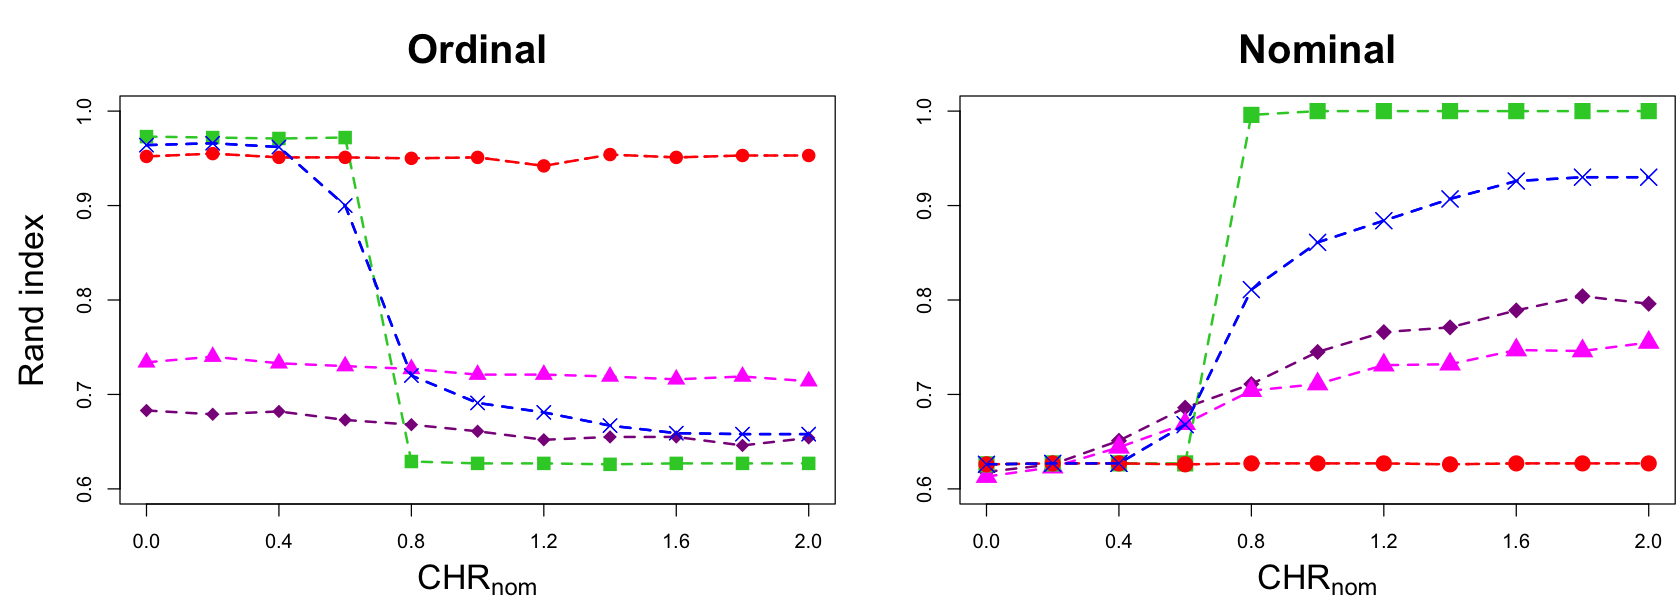

In [126]:
CHR=c(0:10)/5


options(repr.plot.width = 14, repr.plot.height = 5)
par(mfrow=c(1,2))
par(mar=c(4,5,4,0.2))

pch_lst=c(16,4.2,15,17,18)
col_lst=c("red","blue","Lime Green","magenta","Dark Magenta")

###############################
# rand index

plot(CHR,rand_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{nom}$"),ylab="Rand index",main="Ordinal",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1)-0.1)
#TeX("$\\hat{m}_j$")
for(i in c(5:1,2)){
    lines(CHR,rand_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5,cex.lab=1.8)
}

###############################
# rand no index

plot(CHR,rand_no_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{nom}$"),ylab="",main="Nominal",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1)-0.1)

for(i in c(5:1,2)){
    lines(CHR,rand_no_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_no_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.8)
}

# Variable selection

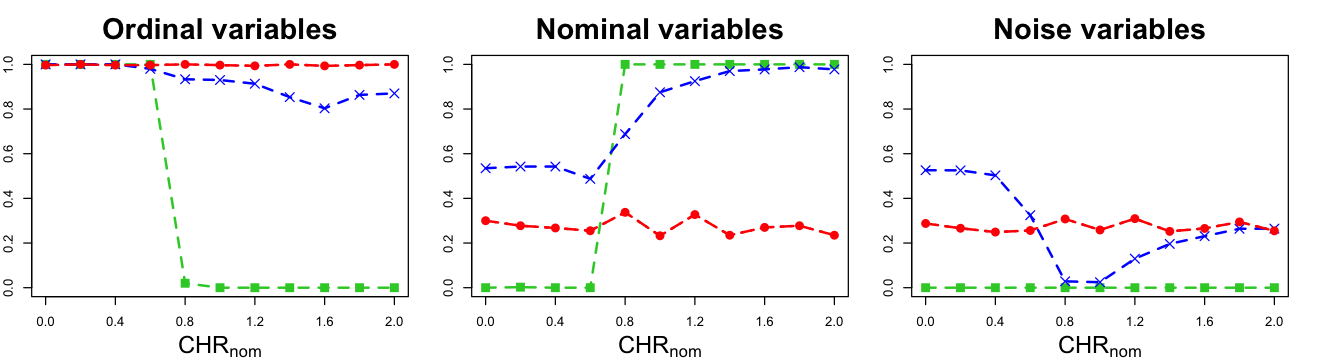

In [117]:

options(repr.plot.width = 11, repr.plot.height = 3)
par(mfrow=c(1,3))
par(mar=c(4,2,3.5,2))


###############################
# Tp of ordinal variables

plot(CHR,tp_ord[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{nom}$"),ylab="",main="Ordinal variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1)-0.1)

for(i in c(3:1)){
    lines(CHR,tp_ord[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_ord[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

###############################
# Tp of nominal variables

plot(CHR,tp_nom[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{nom}$"),ylab="",main="Nominal variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1)-0.1)

for(i in c(3:1)){
    lines(CHR,tp_nom[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_nom[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}
###############################
# Tp of noise variables

plot(CHR,tp_noi[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{nom}$"),ylab="",main="Noise variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1)-0.1)

for(i in c(3:1)){
    lines(CHR,tp_noi[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_noi[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

## Coefficients

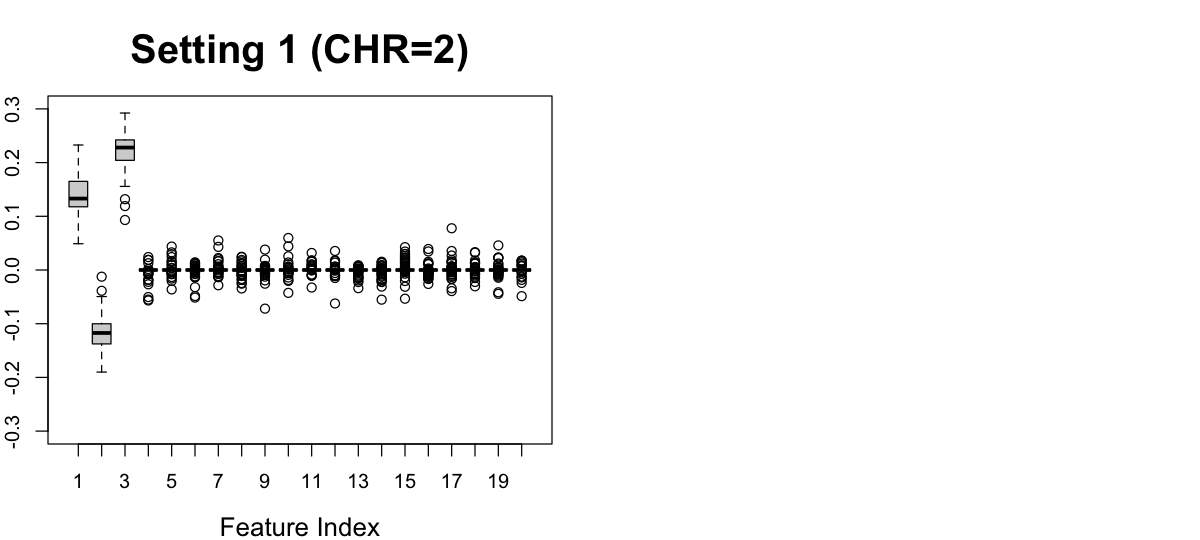

In [118]:
options(repr.plot.width = 10, repr.plot.height = 4.5)
par(mfrow=c(1,2))
par(mar=c(4,2,4,2))


m=coef_mocl_summary(models_10)
#m$coef_mocl_m

boxplot(m$coef_mocl_m,main="Setting 1 (CHR=2)",cex.main=2,cex.lab=1.3,#,xaxt='n',
        xlab="Feature Index",ylab="mean coefficients",cex.axis=1,ylim=c(-0.3,0.3))
#axis(1,at=c(1:20))




## kendall

In [119]:
kendall_summary<-function(models){
    for(i in 1:length(models)){
        if(i==1){
            kendall_lst=models[[i]]$kendall
        }else{
            kendall_lst=c(kendall_lst,models[[i]]$kendall)
        }
    }
    kendall_lst=abs(kendall_lst)
    return(kendall_lst)
}

for(i in 1:length(mm_lst)){
    if(i==1){
        kendalls=kendall_summary(mm_lst[[i]])
    }else{
        kendalls=c(kendalls,kendall_summary(mm_lst[[i]]))
    }
}

In [120]:
cat("kendall mean :",round(mean(kendalls),3))
print("-----------------")
cat("kendall 2se :",round(2*sd(kendalls)/sqrt(length(kendalls)),3))

kendall mean : 0.966[1] "-----------------"
kendall 2se : 0.001